# Activité 2 : l'apprentissage par renforcement avec le deep learning

## 🔍 Recherche d'informations

- Quelles sont les bibliothèques Python pour faire de l'apprentissage par renforcement avec du deep learning ?

- Quelles sont les observations pour le modèle de CartPole ?

- Comment fonctionne un Deep Q Network ?

## 📚 Ressources

- Schéma d'infrastructure :

![schema](schema.webp)

- Tutoriel TF Agents : https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

- Article Medium sur TF Agents : 

    - https://medium.com/analytics-vidhya/tf-agents-a-flexible-reinforcement-learning-library-for-tensorflow-5f125420f64b
    
    - https://medium.com/deep-learning-journals/train-your-dog-using-tf-agents-fba297a85baa

## ✏️ Activités

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

Dans cette partie, on utilisera la bibliothèque [Tf-agents](https://www.tensorflow.org/agents) pour entrainer un Deep Q network dans l'environnement CartPole de Gym. Cette activité s'appuie sur ce tutoriel : https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

### Mise en place des bibliothèques Python

- Installer les bibliothèques Linux suivantes :

```bash
sudo apt-get update
sudo apt-get install -y xvfb ffmpeg freeglut3-dev
```

- Installer les bibliothèques Python suivantes dans un environnement virtuel : 'imageio==2.4.0', pyvirtualdisplay, tf-agents[reverb], pyglet

- Vérifier que les imports de bibliothèques Python s'effectuent correctement (warning possible pour les bibliothèques utilisant des GPU)

In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2022-12-14 22:15:54.775868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 22:16:09.401373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:09.401816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:09.401852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

- Créer une varaible `display` pour afficher l'environnement OpenAI Gym

In [2]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

- Expliquer à quoi correspondent les variables suivantes en ajoutant des commentaires

In [58]:
num_iterations = 3000

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

### Mise en place de l'environnement d'apprentissage par renforcement

In [59]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

- Vérifier l'affichage de l'environnement CartPole

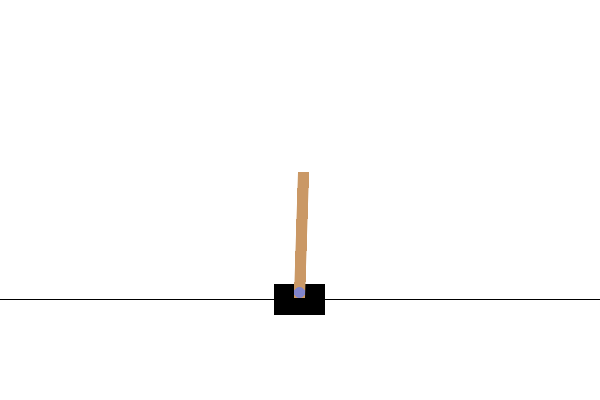

In [60]:
env.reset()
PIL.Image.fromarray(env.render())

- Analyser sous quelles formes sont fournies **les observations**, **les récompenses** et **les actions**

In [61]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


- Le code suivant effectue une **action (action 0)** et **affiche les informations** sur l'environnement avant et après l'action. Vérifier l'effet de l'action en affichant l'image **avant** et **après l'action**

In [62]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(0, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00691415,  0.014473  , -0.00484039,  0.04181991], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00720361, -0.1805792 , -0.00400399,  0.33297172], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


- Deux environnement sont créés pour l'**entrainement** et l'**évaluation** du modèle

In [63]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

- Les environnments sont tranformés pour fonctionner avec la bibliothèque **TensorFlow**

In [64]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Création de l'agent

L'agent utilisé pour cette activité est un [**deep Q network**](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), un réseau de neurones qui peut apprendre les Q-values. On commence par décrire l'**architecture du réseau de neurones**

In [78]:
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

q_net = sequential.Sequential([
    tf.keras.layers.Dense(
      100,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal')
    ),
    tf.keras.layers.Dense(
      50,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal')
    ),
    tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2)
    ),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Politiques (policies)

Pourquoi y a-t-il **2 politiques** pour un agent ?

In [79]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

## Métriques et évaluation

La métrique principale est le nombre de récompenses reçues durant un épisode. Cette valeur est moyennée sur l'ensemble des épisodes joués (average return). **Expliquer le code suivant en le commentant**

In [80]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [81]:
compute_avg_return(eval_env, collect_policy, 100)

9.9

## Replay Buffer

A quoi sert le **Replay Buffer** ?

In [82]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp2rf6rohf.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp2rf6rohf
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33525


## Récupération des données

Expliquer comment fonctionne la **récupération des données**.

In [83]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.03586485,  0.01958713, -0.09746752, -0.16820766], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [85]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

## Entrainement de l'agent

Expliquer le **fonctionnement de l'entrainement de l'agent** 

In [89]:
agent.train_step_counter.assign(0)
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
time_step = train_py_env.reset()
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 37386.33984375
step = 400: loss = 13691.46484375
step = 600: loss = 7946.708984375
step = 800: loss = 65512.25
step = 1000: loss = 4324.68994140625
step = 1000: Average Return = 200.0
step = 1200: loss = 6570.8916015625
step = 1400: loss = 197573.0
step = 1600: loss = 337222.03125
step = 1800: loss = 32543.21484375
step = 2000: loss = 125854.34375
step = 2000: Average Return = 200.0
step = 2200: loss = 186683.171875
step = 2400: loss = 132526.171875
step = 2600: loss = 559738.75
step = 2800: loss = 455416.75
step = 3000: loss = 742431.8125
step = 3000: Average Return = 200.0


## Exploitation des résultats : visualisation


### Graphique

Une itération correspond à 200 pas de temps. La valeur maximale de "average return" est de 200.

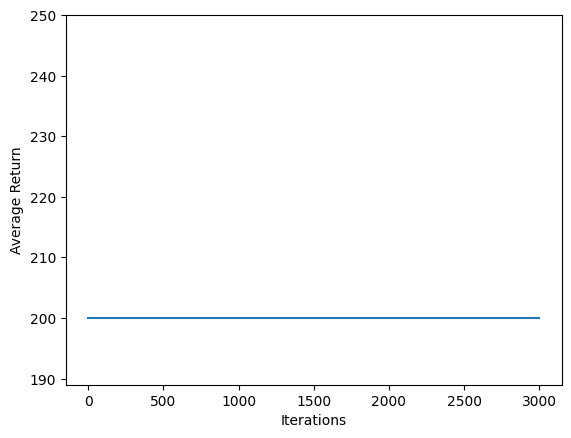

In [90]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)
plt.show()

### Videos

In [76]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [77]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x558d18af2380] Warning: data is not aligned! This can lead to a speed loss


In [ ]:
create_policy_eval_video(random_policy, "random-agent")

## Questions

- Analyser l'impact sur l'average return du nombre de neurones dans les 2 remières couches du réseau de neurones

- Analyser le compromis exploitation / exploration